In [260]:
import pandas as pd
import json
import numpy as np
from pyteomics import mzml

In [261]:
def get_ppm(mz1, mz2):
    return abs((mz1-mz2)/mz1 * 1000000)

In [262]:
#binary search which returns the highest-instensity peak within a ppm tolerance
def binary_search(target, charge, array_mz, array_intensity):
    midpoint = int(len(array_mz)/2)
    try:
        #binary search for any matched array
        if abs(get_ppm(target*charge, array_mz[midpoint]*charge))<= 10:
            return_list = [(array_mz[midpoint],array_intensity[midpoint])]
            offset = 1
            while offset != 0 and (midpoint - offset)>0:
                peak_mz = array_mz[midpoint - offset]
                peak_intensity = array_intensity[midpoint - offset]
                ppm = abs(get_ppm(target*charge, peak_mz*charge))
                if ppm <= 10:
                    return_list.append((peak_mz,peak_intensity))
                    offset += 1
                else:
                    offset = 0
            while offset != 0 and (midpoint + offset < len(array_mz)):
                peak_mz = array_mz[midpoint + offset]
                peak_intensity = array_intensity[midpoint + offset]
                ppm = abs(get_ppm(target*charge, peak_mz*charge))
                if ppm <=10:
                    return_list.append((peak_mz,peak_intensity))
                    offset += 1
                else:
                    offset = 0
            high_intensity_peak = (0,0)
            for key,value in return_list:
                if value > high_intensity_peak[1]:
                    high_intensity_peak = key, value
            return high_intensity_peak
        #cut down array    
        elif len(array_mz)==1 or len(array_mz)==0:
            return 0,0
        elif array_mz[midpoint] <= target:
            return binary_search(target, charge, array_mz[midpoint:], array_intensity[midpoint:])
        else:
            return binary_search(target, charge, array_mz[0:midpoint], array_intensity[0:midpoint])
    except IndexError:
        return 0,0
           

In [263]:
#Calculate weighted average mass, then deuteration of peptide

def calculate_deuteration(dic_peaks, Exchangeable_H, average_mass, charge):
    average_mz = sum([key*value for key, value in dic_peaks.items()])/sum(dic_peaks.values())
    D_uptake = (average_mz*charge - charge*1.007276) - average_mass
    Deuteration = (D_uptake/Exchangeable_H)*100
    return Deuteration


In [264]:
#Peptide_1_mz = [503.3127]       #give a monoisotopic m/z from non-deuterated peptide in the raw file (AngII 2+)
Peptide_1_mz = [377.7374]       #SynII (4+)

Max_D = 20                       #give the maximal deuterium can be labelled on the peptide.(value can be a little bit larger)
Exchangeable_H = 13              #give exchangeable hydrogen  

average_mass = 1507.8406         #give the average mass of the peptide
#SynII = 1507.8406

Charge = 4
Hydrogen_mass = 1.007276
scan_range_start = 300           #give the start scan number
scan_range_end = 400             #give the end scan number
Deuteration_all = []
Retention_time_all = []

In [265]:
#build up peptide library
for i in range(Max_D):
    Deu_mz= Peptide_1_mz[i] + (Hydrogen_mass/Charge)
    Peptide_1_mz.append(Deu_mz)
#print(Peptide_1_mz)

In [266]:
with mzml.read("/Volumes/jbl_data/flashdrive/data/mzML/ExpA026_D2O-Syn2_300lab_10psi_240s-T3.mzML") as reader: #give the mzml path
    for scan in reader:
        if scan["index"] in range(scan_range_start,scan_range_end):
            print(scan["index"])
            scan_time=float(scan["scanList"]["scan"][0]["scan start time"])
            #print(scan_time)
            m_z=scan["m/z array"]
            intensity=scan["intensity array"]
            dic=dict(zip(m_z, intensity))
            dic1={key:value for key, value in dic.items() if value>100 }
            array_mz = list(dic1.keys())
            #print(array_mz)
            array_intensity = list(dic1.values())
            #print(array_mz)
            #print(array_intensity)
            Matched_peaks_in_tuble = ()
            for i in range(len(Peptide_1_mz)):
                #print(i)
                peak = binary_search(Peptide_1_mz[i], Charge, array_mz, array_intensity)
                #print(peak)
                Matched_peaks_in_tuble += ((peak),)
            dic_high_peak = dict((x,y) for x,y in Matched_peaks_in_tuble)
            Deuteration_1= calculate_deuteration(dic_high_peak, Exchangeable_H, average_mass, Charge)
            Deuteration_all.append(Deuteration_1)
            Retention_time_all.append(scan_time)
print(Deuteration_all)
print(Retention_time_all)

300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
[47.46291148439224, 48.17378276684744, 48.35964311668109, 48.282982753436535, 48.56373422933477, 49.1689396579624, 50.374358796566064, 50.32700723417677, 51.46099848893579, 51.33787773348174, 53.641942979293866, 54.742705676765645, 57.05423313163115, 60.54949408356571, 64.61495193191415, 69.88156929057297, 75.55632508841566, 81.43365529603426, 88.02411679110509, 93.18231279619866, 96.4811476080303, 100.33075558907372, 102.44982590000535, 104.80574990520802, 105.54958452614056, 106.90876852485975, 106.02058124626848, 107.65996918511904, 107.58947883820417, 108.29231912909493, 109.51555025118383

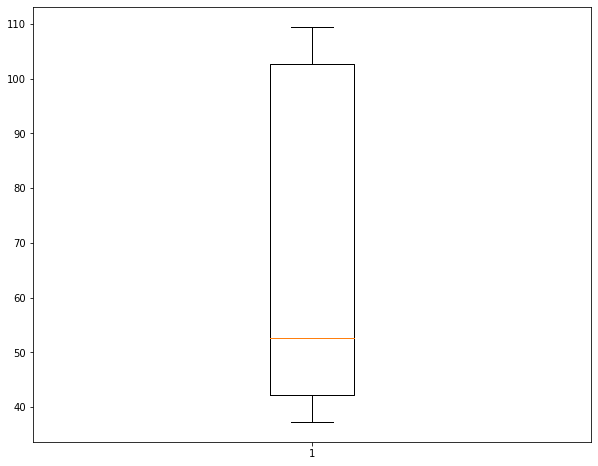

In [267]:
# Plot figure
x = Retention_time_all
y = Deuteration_all

plt.figure(figsize=(10,8))

plt.boxplot(y)

plt.savefig('/Users/JBLangford4/Desktop/Syn2_300lab_T3_box.png',dpi=300) #give path and plot name to save pic

plt.show()

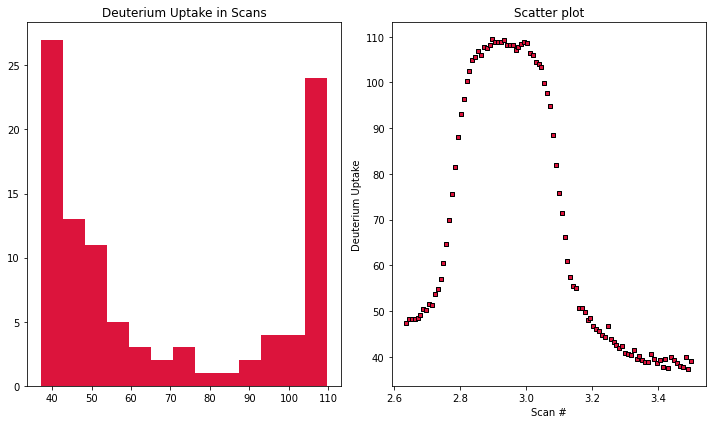

In [268]:
# Plot figure
x = Retention_time_all
y = Deuteration_all

# Plot figure

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.hist(y,
        color = 'crimson',
        bins = 13,
        density = False)

plt.title('Deuterium Uptake in Scans')

plt.subplot(1,2,2)
plt.scatter(x,y,
        c ='crimson',
        s = 10,
        marker = 's',
        edgecolor = 'black')
        
plt.title('Scatter plot')
plt.xlabel('Scan #')
plt.ylabel('Deuterium Uptake')

plt.tight_layout()

plt.savefig('/Users/JBLangford4/Desktop/Syn2_300lab_T3_hist_scat.png',dpi=300) #give path and plot name to save pic

plt.show()

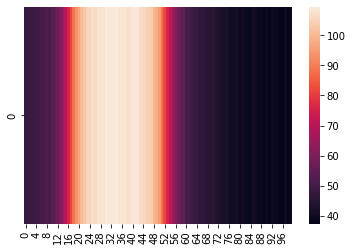

In [269]:
# library
import seaborn as sns
import pandas as pd
import numpy as np

# Plot figure
x = Retention_time_all
y = Deuteration_all

# Create a dataset
df = pd.DataFrame([y])

# Default heatmap
p1 = sns.heatmap(df)

plt.savefig('/Users/JBLangford4/Desktop/Syn2_300lab_T3_htmp_scat.png',dpi=300) #give path and plot name to save pic